In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

In [4]:
class LagrangianDoublePendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L : float
        length of the simple pendulum
    g : float
        gravitational acceleration at the earth's surface
    omega_0 : float
        natural frequency of the pendulum (\sqrt{g/l} where l is the 
        pendulum length) 
    mass : float
        mass of pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, l1=1., l2=1, m1=1., m2=1, g=1.
                ):
        self.l1 = l1
        self.l2 = l2
        self.m1 = m1
        self.m2 = m2
        self.g = g
        self.omega1_0 = np.sqrt(g/l1)
        self.omega2_0 = np.sqrt(g/l2)

        
    def f1(self, y):
        """"
        Parameters
        ----------
        y : float
            A 4-component vector with y[0] = phi1(t), y1[1] = phi2/dt, y[2] = dphi1/dt, and y[3] = dphi2/dt

            
        Returns
        -------
        
        """

        
        return np.array([(-self.l2 / self.l1) * (self.m2 / (self.m1 + self.m2)) * y[3]**2 * np.sin(y[0] - y[1]) 
                   - self.g / self.l1 * np.sin(y[0])])
    
    def f2(self, y):
        """"
        Parameters
        ----------
        y : float
            A 4-component vector with y[0] = phi1(t), y1[1] = phi2(t), y[2] = dphi1/dt, and y[3] = dphi2/dt

            
        Returns
        -------
        
        """

        

        return np.array([(self.l1 / self.l2) * y[2]**2 * np.sin(y[0]-y[1]) 
               - self.g / self.l2 * np.sin(y[1])])
    
    def a1(self, y):
        """"
        Parameters
        ----------
        y : float
            A 4-component vector with y[0] = phi1(t), y1[1] = phi2(t), y[2] = dphi1/dt, and y[3] = dphi2/dt

            
        Returns
        -------
        
        """

        
        return np.array([self.l2 / self.l1 * (self.m2 / (self.m1 + self.m2)) * np.cos(y[0] - y[1])])
    
    def a2(self, y):
        """"
        Parameters
        ----------
        y : float
            A 4-component vector with y[0] = phi1(t), y1[1] = phi2(t), y[2] = dphi1/dt, and y[3] = dphi2/dt

            
        Returns
        -------
        
        """

        

        return np.array([(self.l1 / self.l2) * np.cos(y[0] - y[1])])
    
    def g1(self, y):
        
        return np.array([(self.f1(y) - self.a1(y) * self.f2(y))/(1. - self.a1(y) * self.a2(y))])
    
    def g2(self, y):
        
        return np.array([(-self.a2(y) * self.f1(y) + self.f2(y))/(1. - self.a1(y) * self.a2(y))])
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi1(t), y1[1] = phi2(t), y[2] = dphi1/dt, and y[3] = dphi2/dt
            
        Returns
        -------
        
        """
        
        return[y[2], y[3], self.g1(y), self.g2(y)]
    
    def solve_ode(self, t_pts, phi1_0, phi2_0, phi1_dot_0, phi2_dot_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = np.array([phi1_0, phi2_0, phi1_dot_0, phi2_dot_0]) 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi2, phi1_dot, phi2_dot = solution.y

        return phi1, phi2, phi1_dot, phi2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

l1 = 1.
l2 = 1.
m1 = 1.
m2 = 1.
g = 1


# Instantiate a pendulum 
p1 = LagrangianDoublePendulum(l1=l1, l2=l2, m1=m1, m2=m2, g=g)

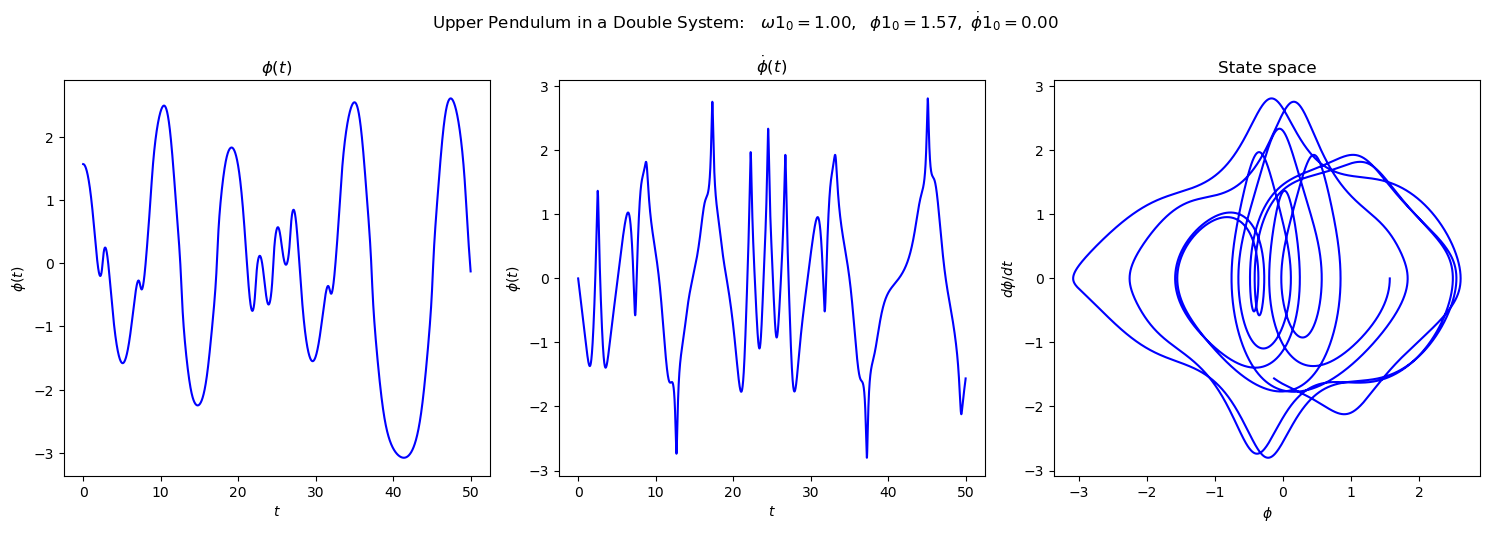

In [8]:
# both plots: same initial conditions
phi1_0 = np.pi/2
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.

phi1, phi2, phi1_dot, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi2_0, phi2_dot_0, phi2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Upper Pendulum in a Double System:  ' + \
                rf' $\omega1_0 = {p1.omega1_0:.2f},$' + \
                rf'  $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi1_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi(t)$', 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1_dot[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\dot\phi(t)$', 
            ax=ax_b)    

# third plot: state space plot from t=30 to t=50   
ax_c = fig.add_subplot(1,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_c)    

fig.tight_layout()
fig.savefig('Double_Pendulum_Langrange_Upper.png', bbox_inches='tight')  

In [9]:
print(phi1_dot[0])

0.0


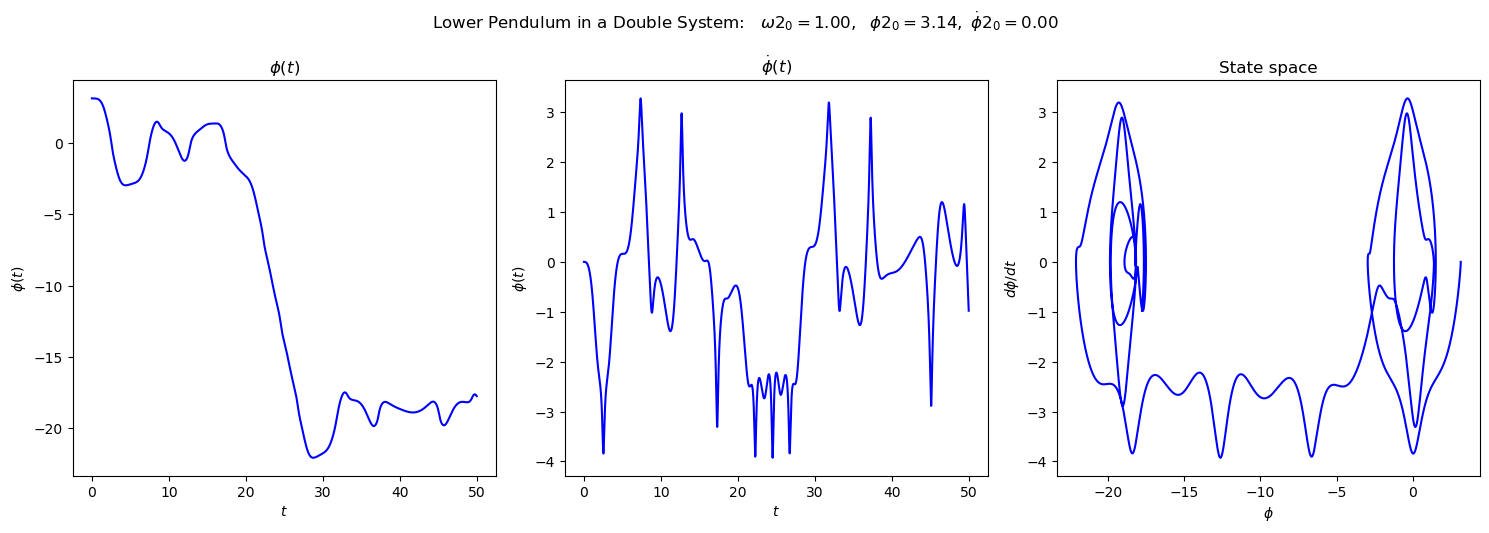

In [10]:
# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Lower Pendulum in a Double System:  ' + \
                rf' $\omega2_0 = {p1.omega2_0:.2f},$' + \
                rf'  $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi2_0 = {phi2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi(t)$', 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi2_dot[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\dot\phi(t)$', 
            ax=ax_b)    

# third plot: state space plot from t=30 to t=50   
ax_c = fig.add_subplot(1,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_c)    

fig.tight_layout()
fig.savefig('Double_Pendulum_Langrange_Lower.png', bbox_inches='tight')  

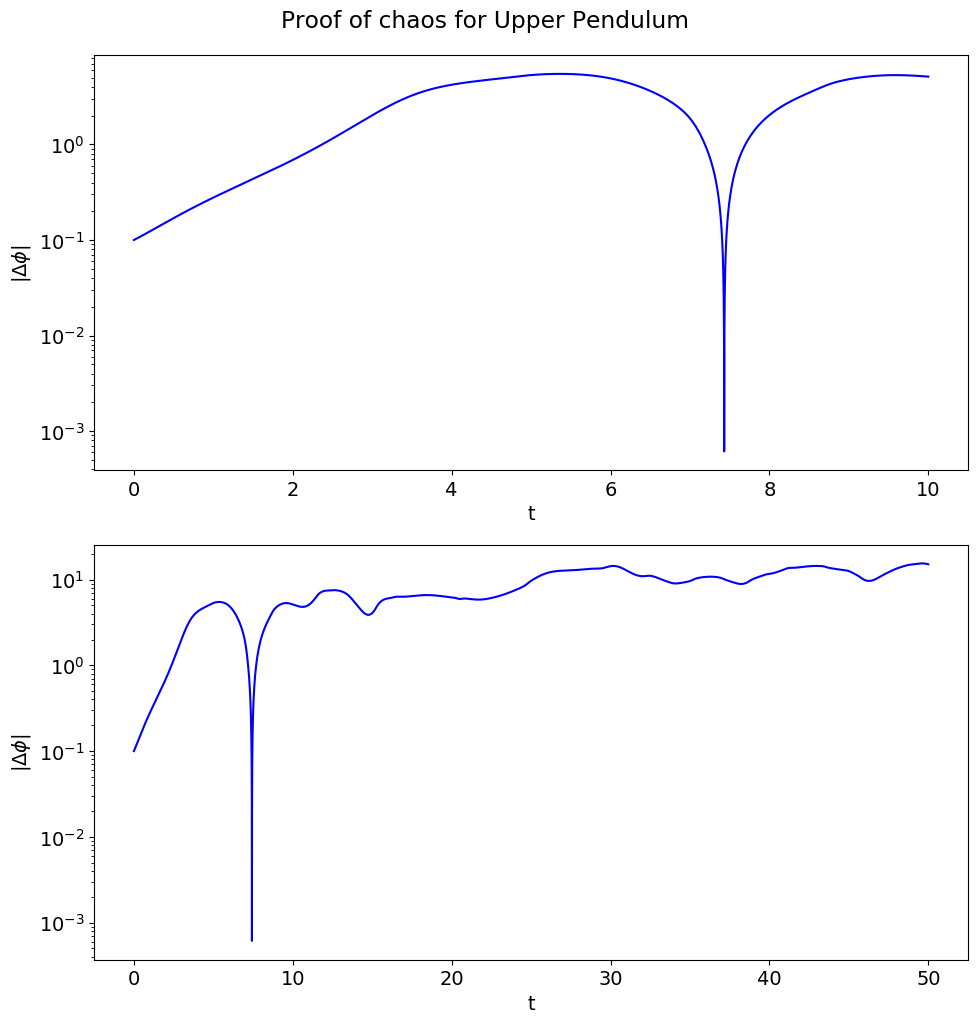

In [11]:
# make a plot of Delta phi for same pendulum but two different initial conds
phi1_0_1 = phi1_0 = -np.pi / 2.
phi1_dot_0 = 0.0
phi2_0_1 = phi2_0 = -np.pi / 2.
phi2_dot_0 = 0.0
phi1_1, phi2_1, phi1_dot_1, phi2_dot_1 = p1.solve_ode(t_pts, phi1_0_1, phi1_dot_0, phi2_0_1, phi2_dot_0,
                                abserr=1.e-10, relerr=1.e-10)

phi1_0_2 = phi1_0_1 - .1   # .1 radian lower
phi2_0_2 = phi1_0_1 - .1
phi1_2, phi2_2, phi1_dot_2, phi2_dot_2 = p1.solve_ode(t_pts, phi1_0_2, phi1_dot_0, phi2_0_2, phi2_dot_0,
                                abserr=1.e-10, relerr=1.e-10)

# Calculate the absolute value of \phi_2 - \phi_1
Delta_phi1 = np.fabs(phi1_2 - phi1_1)
Delta_phi2 = np.fabs(phi2_2 - phi2_1)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = 'Proof of chaos for Upper Pendulum ' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# two plot: plot from t=0 to t=8 and another from t=0 to t=100 
ax_a = fig.add_subplot(2,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)
ax_a.semilogy(t_pts[start : stop], Delta_phi1[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi|$')

ax_b = fig.add_subplot(2,1,2)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi1[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\phi|$')
                              
fig.tight_layout()
# always bbox_inches='tight' for best results.  Further adjustments also.
fig.savefig('Chaos_Upper.png', bbox_inches='tight')  

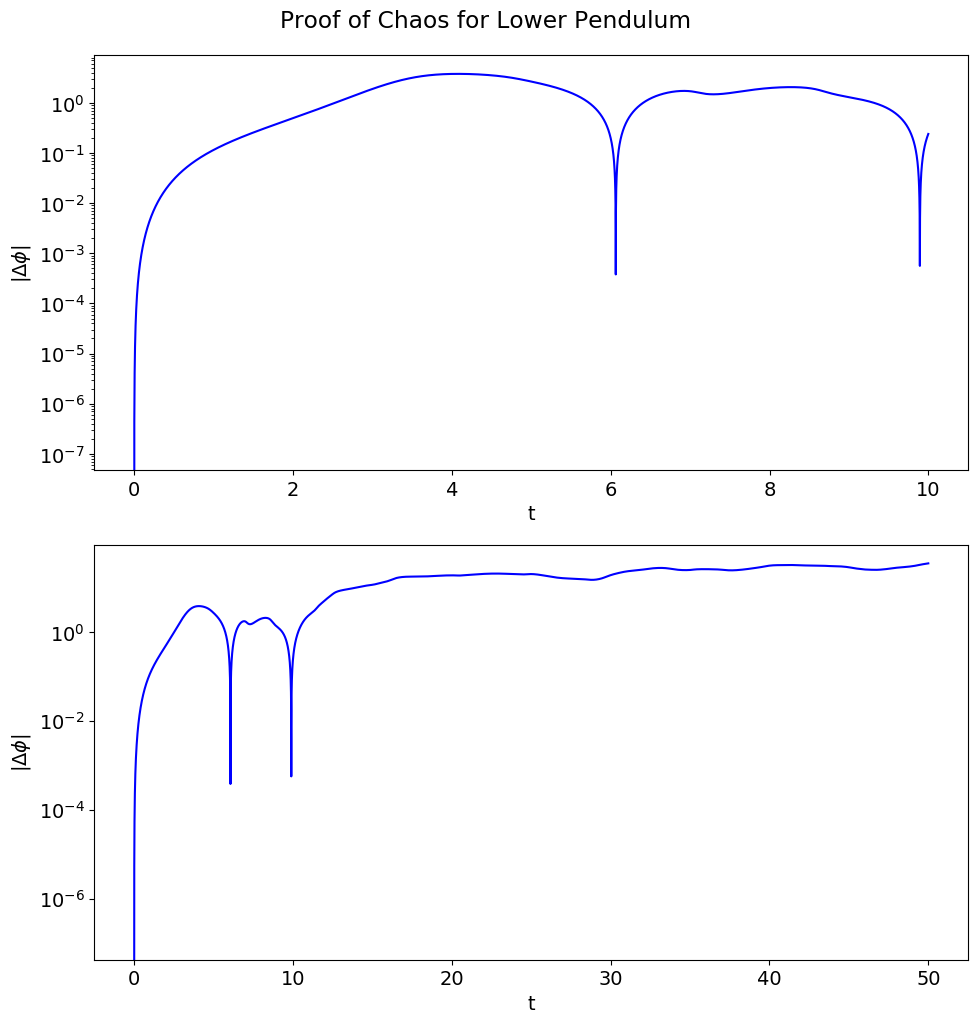

In [12]:
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = 'Proof of Chaos for Lower Pendulum ' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# two plot: plot from t=0 to t=8 and another from t=0 to t=100 
ax_a = fig.add_subplot(2,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)
ax_a.semilogy(t_pts[start : stop], Delta_phi2[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi|$')

ax_b = fig.add_subplot(2,1,2)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\phi|$')
                              
fig.tight_layout()
# always bbox_inches='tight' for best results.  Further adjustments also.
fig.savefig('Chaos_Lower.png', bbox_inches='tight')  